## Assessing the antibody validation status 

**Input:**  Antibody validation status obtained from <a href="https://api.gdc.cancer.gov/v0/data/62647302-b4d3-4a81-a7c0-d141f5dbd300">GDC reference files</a> and TCGA Pan-Cancer Protein data

**Output:** Supplemental Table 1 and Figure 1

### Import Packages

In [1]:
import os, re
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

import graphing_utils
import customized_plot 
from matplotlib import pyplot as plt

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_table_path = lambda fname: os.path.normpath('../tables/' + fname)
get_figure_path = lambda fname: os.path.normpath('../figures/' + fname)

file_antibody_tcga = get_data_path(['gdc_cancer_gov'], 'TCGA_antibodies_descriptions.gencode.v36.tsv')
file_pancan_rppa = get_data_path(['usc_xena_browser'], 'TCGA-RPPA-pancan-clean.xena')

file_sourceData_Figure1 = get_table_path('SourceDataForFigure1.csv')
file_table_s1 = get_table_path('TableS1.csv')

### Load data

In [3]:
antibody_tcga_status = pd.read_csv(file_antibody_tcga, sep='\t', usecols=['peptide_target', 'gene_name', 'antibody_origin', 
                                                                          'source', 'catalog_number', 'validation_status'])
print("Dimensions:", antibody_tcga_status.shape)
antibody_tcga_status[:2]

Dimensions: (487, 6)


,peptide_target,gene_name,antibody_origin,source,catalog_number,validation_status
0,1433BETA,YWHAB,Rabbit,Santa Cruz,sc-628,Valid
1,1433EPSILON,YWHAE,Mouse,Santa Cruz,sc-23957,Caution


In [4]:
antibody_tcga_status['validation_status'].value_counts()

Valid               283
Caution             197
Under Evaluation      7
Name: validation_status, dtype: int64

<div class="alert alert-block alert-warning">
    We include antibodies in our analyses only when it:
    <li> is present in the TCGA Pan-Cancer RPPA data </li>   
    <li> is marked as 'Valid' or 'Caution'</li>
    <li> targets no more than one protein</li>
    <li> does not target phosphoproteins </li>
   
</div>

#### Load TCGA Pan-Cancer RPPA data 

In [5]:
pancan_rppa = pd.read_csv(file_pancan_rppa, sep='\t')
print("Dimensions:", pancan_rppa.shape)
pancan_rppa[:2]

Dimensions: (258, 7755)


,SampleID,TCGA-FI-A2EY-01,TCGA-DF-A2KS-01,TCGA-A5-A1OH-01,TCGA-AX-A2H7-01,TCGA-AX-A2HA-01,TCGA-A5-A2K4-01,TCGA-EY-A2OM-01,TCGA-EY-A2ON-01,TCGA-E6-A2P8-01,...,TCGA-RD-A8N0-01,TCGA-RD-A8MW-01,TCGA-VQ-A8E2-01,TCGA-VQ-A8E0-01,TCGA-VQ-A8DL-01,TCGA-VQ-A8DU-01,TCGA-VQ-A8DT-01,TCGA-IN-A7NR-01,TCGA-RD-A8MV-01,TCGA-KB-A93G-01
0,X1433EPSILON,-0.013829,-0.16863,0.038842,0.021308,0.108640,-0.24198,0.051101,0.183180,-0.062962,...,-0.30092,-0.006139,-0.022418,0.001432,0.027505,-0.048516,-0.13928,-0.23253,-0.019379,-0.064041
1,X4EBP1,-1.127400,0.16587,-0.382370,-0.717660,0.090459,-0.37866,-0.044557,-0.053956,0.008223,...,-0.48837,-0.321200,-0.386970,0.018423,-0.325220,-0.073244,-0.16909,-0.50985,0.250550,-0.247550


In [6]:
pancan_rppa_renamed = pancan_rppa.rename(columns={'SampleID': 'peptide_target'})
# antibody name that begins with a number is prefixed with an 'X' for e.g., X1433EPSILON should be 1433EPSILON, 
# so trying to get rid of the X using regex
pancan_rppa_renamed['peptide_target'] = pancan_rppa_renamed['peptide_target'].replace(r"^X(\d)", r"\1", regex=True)
pancan_rppa_renamed[:2]

,peptide_target,TCGA-FI-A2EY-01,TCGA-DF-A2KS-01,TCGA-A5-A1OH-01,TCGA-AX-A2H7-01,TCGA-AX-A2HA-01,TCGA-A5-A2K4-01,TCGA-EY-A2OM-01,TCGA-EY-A2ON-01,TCGA-E6-A2P8-01,...,TCGA-RD-A8N0-01,TCGA-RD-A8MW-01,TCGA-VQ-A8E2-01,TCGA-VQ-A8E0-01,TCGA-VQ-A8DL-01,TCGA-VQ-A8DU-01,TCGA-VQ-A8DT-01,TCGA-IN-A7NR-01,TCGA-RD-A8MV-01,TCGA-KB-A93G-01
0,1433EPSILON,-0.013829,-0.16863,0.038842,0.021308,0.108640,-0.24198,0.051101,0.183180,-0.062962,...,-0.30092,-0.006139,-0.022418,0.001432,0.027505,-0.048516,-0.13928,-0.23253,-0.019379,-0.064041
1,4EBP1,-1.127400,0.16587,-0.382370,-0.717660,0.090459,-0.37866,-0.044557,-0.053956,0.008223,...,-0.48837,-0.321200,-0.386970,0.018423,-0.325220,-0.073244,-0.16909,-0.50985,0.250550,-0.247550


In [7]:
# remove antibodies that map to phospho-proteins
pancan_rppa_renamed = pancan_rppa_renamed[pancan_rppa_renamed["peptide_target"].str.contains("_p") == False]
print("Number of antibodies which are mapped to only proteins", pancan_rppa_renamed.shape[0])

Number of antibodies which are mapped to only proteins 200


In [8]:
len(np.intersect1d(pancan_rppa_renamed['peptide_target'], antibody_tcga_status['peptide_target']))

189

In [9]:
common_proteins = np.intersect1d(pancan_rppa_renamed['peptide_target'], antibody_tcga_status['peptide_target'])
common_proteins

array(['1433BETA', '1433EPSILON', '1433ZETA', '4EBP1', '53BP1', 'ACC1',
       'ACETYLATUBULINLYS40', 'ACVRL1', 'ADAR1', 'AKT', 'ALPHACATENIN',
       'AMPKALPHA', 'ANNEXIN1', 'ANNEXINVII', 'AR', 'ARAF', 'ARID1A',
       'ASNS', 'ATM', 'AXL', 'BAK', 'BAP1C4', 'BAX', 'BCL2', 'BCL2A1',
       'BCLXL', 'BECLIN', 'BETACATENIN', 'BID', 'BIM', 'BRAF', 'BRCA2',
       'BRD4', 'CA9', 'CABL', 'CASPASE3', 'CASPASE7CLEAVEDD198',
       'CASPASE8', 'CASPASE9', 'CAVEOLIN1', 'CD20', 'CD26', 'CD31',
       'CD49B', 'CDK1', 'CHK1', 'CHK2', 'CIAP', 'CKIT', 'CLAUDIN7',
       'CMET', 'CMYC', 'COG3', 'COLLAGENVI', 'COMPLEXIISUBUNIT30', 'CRAF',
       'CTLA4', 'CYCLINB1', 'CYCLIND1', 'CYCLINE1', 'CYCLINE2', 'DIRAS3',
       'DJ1', 'DUSP4', 'DVL3', 'E2F1', 'ECADHERIN', 'EEF2', 'EEF2K',
       'EGFR', 'EIF4E', 'EIF4G', 'ENY2', 'EPPK1', 'ERALPHA', 'ERCC1',
       'ERCC5', 'ERK2', 'ETS1', 'EZH2', 'FASN', 'FIBRONECTIN', 'FOXM1',
       'FOXO3A', 'G6PD', 'GAB2', 'GAPDH', 'GATA3', 'GATA6', 'GCN5L2',
       'GSK3

In [10]:
antibody_tcga_status = antibody_tcga_status[antibody_tcga_status['peptide_target'].isin(common_proteins)]
antibody_tcga_status['validation_status'].value_counts()

Valid               114
Caution              68
Under Evaluation      7
Name: validation_status, dtype: int64

In [11]:
antibody_tcga_status['validation_status'].value_counts(normalize=True)

Valid               0.603175
Caution             0.359788
Under Evaluation    0.037037
Name: validation_status, dtype: float64

In [12]:
# removing antibodies without nay validation status
antibody_tcga_status = antibody_tcga_status[~(antibody_tcga_status['validation_status'] == 'Under Evaluation')]
# getting rid of antibodies that map to more than one protein (delimiter used is '/')
antibody_tcga_status = antibody_tcga_status[~(antibody_tcga_status['gene_name'].str.contains('/'))]

In [13]:
# find duplicate genes 
antibody_tcga_status[antibody_tcga_status['gene_name'].isin(antibody_tcga_status[antibody_tcga_status.duplicated(subset=['gene_name'])]['gene_name'].to_list())]

,peptide_target,gene_name,antibody_origin,source,catalog_number,validation_status
335,PARP1,PARP1,Rabbit,Santa Cruz,sc-7150,Caution
336,PARPCLEAVED,PARP1,Mouse,CST,9546,Caution


In [14]:
antibody_tcga_status[antibody_tcga_status['gene_name'].isin(['RB1', 'SETD2', 'DIABLO', 'SNAI1', 
                                                             'ERCC1', 'CASP8', 'MET', 'CTNNA1'])]

,peptide_target,gene_name,antibody_origin,source,catalog_number,validation_status
21,ALPHACATENIN,CTNNA1,Mouse,Millipore,CA1030,Valid
77,CASPASE8,CASP8,Mouse,CST,9746,Caution
111,CMET,MET,Mouse,CST,3127,Caution
172,ERCC1,ERCC1,Mouse,Lab Vision,MS-671,Valid
392,RB,RB1,Mouse,CST,9309,Caution
412,SETD2,SETD2,Rabbit,Abcam,ab69836,Caution
423,SMAC,DIABLO,Mouse,CST,2954,Caution
427,SNAIL,SNAI1,Mouse,CST,3895,Caution


<div class="alert alert-block alert-info">
    PARPCLEAVED antibody is used for quality control,  ALPHACATENIN is discontinued - information obtained from Dr. Yiling Lu. 
</div>

In [15]:
antibody_tcga_status = antibody_tcga_status[~(antibody_tcga_status['gene_name'].isin(['CTNNA1']))]

In [16]:
antibody_tcga_status.drop_duplicates(subset='gene_name', keep="first", inplace=True)

In [17]:
antibody_tcga_status['validation_status'].value_counts()

Valid      110
Caution     63
Name: validation_status, dtype: int64

In [18]:
antibody_tcga_status['validation_status'].value_counts(normalize=True)

Valid      0.635838
Caution    0.364162
Name: validation_status, dtype: float64

In [19]:
antibody_tcga_status.rename(columns={'peptide_target': 'PeptideTarget', 'gene_name': 'GeneName', 
                                     'antibody_origin': 'AntibodyOrigin', 'source': 'Source', 
                                     'catalog_number': 'CatalogNumber', 'validation_status': 'ValidationStatus'}, inplace=True)
antibody_tcga_status.replace('Caution', 'Use with Caution', inplace=True)
antibody_tcga_status.to_csv(file_table_s1, index=False)
antibody_tcga_status[:2]

,PeptideTarget,GeneName,AntibodyOrigin,Source,CatalogNumber,ValidationStatus
0,1433BETA,YWHAB,Rabbit,Santa Cruz,sc-628,Valid
1,1433EPSILON,YWHAE,Mouse,Santa Cruz,sc-23957,Use with Caution


In [20]:
antibody_tcga_status_subset = antibody_tcga_status[['PeptideTarget', 'GeneName', 'ValidationStatus']]

In [21]:
file_sourceData_Figure1 = get_table_path('SourceDataForFigure1.csv')
antibody_tcga_status_subset.to_csv(file_sourceData_Figure1, index=False)
antibody_tcga_status_subset[:2]

,PeptideTarget,GeneName,ValidationStatus
0,1433BETA,YWHAB,Valid
1,1433EPSILON,YWHAE,Use with Caution


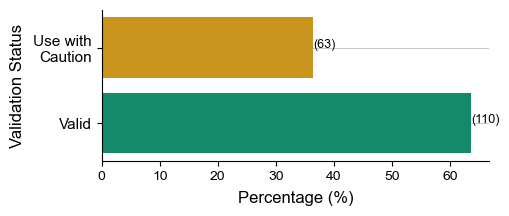

In [22]:
palette = [graphing_utils.get_color(color) for color in ['orange', 'green']]
args = graphing_utils.additional_plot_parameters(xlab="Percentage (%)", ylab="Validation Status", 
                                                             palette = palette)
percentage = lambda i: len(i) / float(len(x)) * 100
with plt.rc_context({'axes.linewidth': 0.8, 'axes.labelsize':12, 'axes.spines.left': True, 'xtick.labelsize':10, 
                     'ytick.labelsize':11}):
    figure, ax = plt.subplots(1, 1, figsize=(5, 2))
    customized_plot.draw_countplot(antibody_tcga_status_subset, ax, args)
    figure.savefig(get_figure_path('Figure1.svg'), bbox_inches='tight', dpi=300)

<div class="alert alert-block alert-success">
    ~36% of the antibodies used for TCGA RPPA studies are not reliable!!
</div>